In [1]:
import os
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab - Setting up environment...")
    from google.colab import drive
    drive.mount('/content/drive')
    
    repo_url = "https://github.com/pooyaht/dl_hw2"
    clone_path = "/content/drive/MyDrive/dl_hw2"
    
    if not os.path.exists(clone_path):
        print(f"Cloning repository to {clone_path}...")
        !git clone {repo_url} {clone_path}
    else:
        print(f"Repository already exists at {clone_path}")
    
    os.chdir(clone_path)
    print(f"Changed working directory to: {os.getcwd()}")
    
    if clone_path not in sys.path:
        sys.path.append(clone_path)
else:
    print("Running locally")

Running locally


In [2]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

from pathlib import Path

from coco_downloader import COCOCatDogDownloader
from resnet_YOLO_model import ResNetYOLODetector
from dataloader import create_split_datasets, create_dataloaders
from yolo_helpers import create_yolo_targets, decode_yolo_predictions, yolo_loss

In [3]:
downloader = COCOCatDogDownloader()
downloader.download_and_prepare_dataset()

Annotations already exist, skipping download
loading annotations into memory...
Done (t=11.82s)
creating index...
index created!
Cat category ID: [17]
Dog category ID: [18]
Found 4078 pure cat images
Found 4342 pure dog images
Found 220 mixed images
Selected 220 mixed images (all)
Selected 2500 pure cat images
Selected 2500 pure dog images


100%|██████████| 5220/5220 [00:00<00:00, 99494.97it/s]


In [4]:
annotations_file = "cat_dog_images/cat_dog_annotations.json"

train_file, val_file = create_split_datasets(
    annotations_file, val_ratio=0.2)

train_loader, val_loader = create_dataloaders(
    train_file, val_file,
    images_dir="cat_dog_images",  
    batch_size=16,
    target_size=(224, 224)  
)


Split Results:
Training set: 4176 images
- Mixed: 176
- Pure cat: 2000
- Pure dog: 2000
Validation set: 1044 images
- Mixed: 44
- Pure cat: 500
- Pure dog: 500

Saved:
- Training annotations: cat_dog_images/train_annotations.json
- Validation annotations: cat_dog_images/val_annotations.json


In [5]:
def calculate_anchors(train_loader, num_anchors=3, grid_size=14):
    all_boxes = []
    for _, targets in train_loader:
        for target in targets:
            for box in target['boxes']:
                w = (box[2] - box[0]) * grid_size / 224
                h = (box[3] - box[1]) * grid_size / 224
                all_boxes.append([w.item(), h.item()])
    
    kmeans = KMeans(n_clusters=num_anchors, random_state=42)
    kmeans.fit(all_boxes)
    return kmeans.cluster_centers_

anchors = calculate_anchors(train_loader)
anchors = np.sort(anchors, axis=0)
anchors = anchors.astype(np.float32)
anchors

array([[ 2.1473207,  2.423694 ],
       [ 5.599614 ,  6.388466 ],
       [ 9.837961 , 10.578161 ]], dtype=float32)

In [6]:
def train_epoch(model, anchors, train_loader, optimizer, scheduler, device, epoch):
    model.train()
    model.update_epoch(epoch, partial_unfreeze_layers=2)
    
    running_losses = {'total': 0.0, 'xy': 0.0, 'wh': 0.0, 'obj': 0.0, 'noobj': 0.0, 'cls': 0.0}
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    
    for batch_idx, (images, targets) in enumerate(pbar):
        images = torch.stack(images).to(device)
        
        yolo_targets = create_yolo_targets(
            targets, 
            anchors
        ).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        losses = yolo_loss(outputs, yolo_targets)
        losses['total_loss'].backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        for key in running_losses:
            if key == 'total':
                running_losses[key] += losses['total_loss'].item()
            else:
                loss_key = f'{key}_loss'
                if loss_key in losses:
                    running_losses[key] += losses[loss_key].item()

        if batch_idx % 10 == 0:
            avg_loss = running_losses['total'] / (batch_idx + 1)
            current_lr = optimizer.param_groups[0]['lr']
            pbar.set_postfix({'loss': f'{avg_loss:.4f}', 'lr': f'{current_lr:.2e}'})
    
    scheduler.step()
    
    num_batches = len(train_loader)
    avg_losses = {key: running_losses[key] / num_batches for key in running_losses}
    
    return avg_losses

def validate_epoch(model, anchors, val_loader, device):
    model.eval()
    
    running_losses = {'total': 0.0, 'xy': 0.0, 'wh': 0.0, 'obj': 0.0, 'noobj': 0.0, 'cls': 0.0}
    
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc='Validation'):
            images = torch.stack(images).to(device)
            
            yolo_targets = create_yolo_targets(
                targets, 
                anchors
            ).to(device)
            
            outputs = model(images)
            losses = yolo_loss(outputs, yolo_targets)
            
            for key in running_losses:
                if key == 'total':
                    running_losses[key] += losses['total_loss'].item()
                else:
                    loss_key = f'{key}_loss'
                    if loss_key in losses:
                        running_losses[key] += losses[loss_key].item()
    
    num_batches = len(val_loader)
    avg_losses = {key: running_losses[key] / num_batches for key in running_losses}
    
    return avg_losses

MPS available: Using Apple Silicon GPU
Using device: mps
Training samples: 4176
Validation samples: 1044


Using cache found in /Users/tobysmith/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/tobysmith/Desktop/Desktop/dev/python/ML/DL/HW2/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tobysmith/Desktop/Desktop/dev/python/ML/DL/HW2/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Backbone resnet50 configured for 14x14 grid
Output channels: 2048
Approximate backbone parameters: 23.5M
Model Information:
  total_parameters: 46,601,301
  trainable_parameters: 23,093,269
  backbone_parameters: 23,508,032
  adapter_parameters: 13,643,776
  head_parameters: 9,449,493
  backbone_frozen: 1
  current_epoch: 0

Epoch 1/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:21<00:00,  3.03it/s]


Train - Total: 216.2343, XY: 39.0539, WH: 27.1360, Obj: 8.0226, NoObj: 13.5474, Cls: 2.8682
Val   - Total: 73.2703, XY: 16.3883, WH: 4.7630, Obj: 6.4626, NoObj: 2.8140, Cls: 1.9469
Current LR: 2.99e-04
Saved best model with validation loss: 73.2703

Epoch 2/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:17<00:00,  3.83it/s]


Train - Total: 136.0946, XY: 26.0466, WH: 15.8142, Obj: 6.6195, NoObj: 3.3393, Cls: 2.2229
Val   - Total: 80.8859, XY: 18.1025, WH: 5.6471, Obj: 6.2915, NoObj: 2.8229, Cls: 1.9341
Current LR: 2.95e-04

Epoch 3/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:16<00:00,  3.96it/s]


Train - Total: 82.4853, XY: 16.9197, WH: 7.3715, Obj: 6.0945, NoObj: 2.9103, Cls: 2.0622
Val   - Total: 80.1965, XY: 17.1298, WH: 6.1861, Obj: 6.9528, NoObj: 2.7595, Cls: 1.9162
Current LR: 2.90e-04

Epoch 4/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:16<00:00,  3.90it/s]


Train - Total: 56.8720, XY: 12.6888, WH: 3.2757, Obj: 5.6022, NoObj: 2.8045, Cls: 1.9741
Val   - Total: 52.4912, XY: 11.9714, WH: 2.5644, Obj: 5.8625, NoObj: 2.3866, Cls: 1.8280
Current LR: 2.82e-04
Saved best model with validation loss: 52.4912

Epoch 5/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:16<00:00,  3.95it/s]


Train - Total: 53.1715, XY: 12.0400, WH: 2.7299, Obj: 5.6054, NoObj: 2.6784, Cls: 1.9171
Val   - Total: 51.5475, XY: 11.9698, WH: 2.2928, Obj: 5.4567, NoObj: 2.9578, Cls: 1.8243
Current LR: 2.72e-04
Saved best model with validation loss: 51.5475

Epoch 6/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:16<00:00,  3.95it/s]


Train - Total: 52.6316, XY: 11.9947, WH: 2.6193, Obj: 5.5434, NoObj: 2.7115, Cls: 1.8903
Val   - Total: 50.9926, XY: 12.0960, WH: 1.9976, Obj: 5.8761, NoObj: 2.0698, Cls: 1.8007
Current LR: 2.60e-04
Saved best model with validation loss: 50.9926

Epoch 7/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:16<00:00,  3.88it/s]


Train - Total: 49.8461, XY: 11.6289, WH: 2.0700, Obj: 5.5010, NoObj: 2.7055, Cls: 1.8957
Val   - Total: 48.2869, XY: 11.6750, WH: 1.5489, Obj: 5.5303, NoObj: 2.5427, Cls: 1.8134
Current LR: 2.46e-04
Saved best model with validation loss: 48.2869

Epoch 8/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.62it/s]


Train - Total: 48.9517, XY: 11.4623, WH: 1.9771, Obj: 5.4631, NoObj: 2.6191, Cls: 1.8609
Val   - Total: 49.4536, XY: 11.9397, WH: 1.6680, Obj: 5.6614, NoObj: 2.3463, Cls: 1.7959
Current LR: 2.31e-04

Epoch 9/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:17<00:00,  3.84it/s]


Train - Total: 49.9177, XY: 11.7208, WH: 2.0461, Obj: 5.4607, NoObj: 2.6074, Cls: 1.8524
Val   - Total: 47.6627, XY: 11.4871, WH: 1.5560, Obj: 5.6133, NoObj: 2.2900, Cls: 1.7750
Current LR: 2.15e-04
Saved best model with validation loss: 47.6627

Epoch 10/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:17<00:00,  3.83it/s]


Train - Total: 46.6971, XY: 10.9550, WH: 1.7602, Obj: 5.3679, NoObj: 2.6686, Cls: 1.8491
Val   - Total: 48.1572, XY: 11.6620, WH: 1.5316, Obj: 5.5599, NoObj: 2.4119, Cls: 1.8103
Current LR: 1.97e-04

Epoch 11/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:17<00:00,  3.87it/s]


Train - Total: 45.8319, XY: 10.7997, WH: 1.6383, Obj: 5.4008, NoObj: 2.5952, Cls: 1.8192
Val   - Total: 48.1835, XY: 11.6171, WH: 1.6062, Obj: 5.4250, NoObj: 2.5992, Cls: 1.7890
Current LR: 1.79e-04

Epoch 12/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:16<00:00,  3.94it/s]


Train - Total: 44.9346, XY: 10.6016, WH: 1.5506, Obj: 5.3520, NoObj: 2.6080, Cls: 1.8219
Val   - Total: 47.6701, XY: 11.5300, WH: 1.5187, Obj: 5.2575, NoObj: 2.9358, Cls: 1.7986
Current LR: 1.61e-04

Epoch 13/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:16<00:00,  3.91it/s]


Train - Total: 44.8319, XY: 10.4657, WH: 1.6533, Obj: 5.3630, NoObj: 2.5914, Cls: 1.8164
Val   - Total: 47.8899, XY: 11.6515, WH: 1.4946, Obj: 5.4144, NoObj: 2.4983, Cls: 1.7879
Current LR: 1.42e-04

Epoch 14/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:16<00:00,  4.01it/s]


Train - Total: 44.3868, XY: 10.3783, WH: 1.6041, Obj: 5.3213, NoObj: 2.6261, Cls: 1.8051
Val   - Total: 47.6860, XY: 11.5989, WH: 1.4681, Obj: 5.5443, NoObj: 2.3184, Cls: 1.7816
Current LR: 1.24e-04

Epoch 15/25
--------------------------------------------------
Epoch 15: Unfroze last 2 backbone layers


Validation: 100%|██████████| 66/66 [00:16<00:00,  4.00it/s]


Train - Total: 46.1459, XY: 10.8236, WH: 1.7286, Obj: 5.2870, NoObj: 2.7619, Cls: 1.8212
Val   - Total: 47.1330, XY: 11.5341, WH: 1.3481, Obj: 5.4336, NoObj: 2.5131, Cls: 1.7961
Current LR: 1.06e-04
Saved best model with validation loss: 47.1330

Epoch 16/25
--------------------------------------------------
Epoch 16: Unfroze last 2 backbone layers


Validation: 100%|██████████| 66/66 [00:16<00:00,  3.98it/s]


Train - Total: 43.2970, XY: 10.2423, WH: 1.3697, Obj: 5.2803, NoObj: 2.7179, Cls: 1.8214
Val   - Total: 46.9126, XY: 11.5026, WH: 1.3186, Obj: 5.4360, NoObj: 2.4375, Cls: 1.7944
Current LR: 8.83e-05
Saved best model with validation loss: 46.9126

Epoch 17/25
--------------------------------------------------
Epoch 17: Unfroze last 2 backbone layers


Validation: 100%|██████████| 66/66 [00:16<00:00,  3.98it/s]


Train - Total: 41.3471, XY: 9.7600, WH: 1.2261, Obj: 5.2676, NoObj: 2.6274, Cls: 1.8073
Val   - Total: 46.6122, XY: 11.4582, WH: 1.2947, Obj: 5.3448, NoObj: 2.5064, Cls: 1.7554
Current LR: 7.19e-05
Saved best model with validation loss: 46.6122

Epoch 18/25
--------------------------------------------------
Epoch 18: Unfroze last 2 backbone layers


Validation: 100%|██████████| 66/66 [00:16<00:00,  3.96it/s]


Train - Total: 39.1512, XY: 9.0363, WH: 1.2203, Obj: 5.2622, NoObj: 2.6109, Cls: 1.8139
Val   - Total: 47.2023, XY: 11.6539, WH: 1.2904, Obj: 5.3851, NoObj: 2.4475, Cls: 1.7605
Current LR: 5.68e-05

Epoch 19/25
--------------------------------------------------
Epoch 19: Unfroze last 2 backbone layers


Validation: 100%|██████████| 66/66 [00:18<00:00,  3.53it/s]


Train - Total: 35.8234, XY: 8.0404, WH: 1.1283, Obj: 5.2222, NoObj: 2.6072, Cls: 1.7917
Val   - Total: 48.8968, XY: 12.2099, WH: 1.3044, Obj: 5.2985, NoObj: 2.5525, Cls: 1.7793
Current LR: 4.32e-05

Epoch 20/25
--------------------------------------------------
Epoch 20: Unfroze last 2 backbone layers


Validation: 100%|██████████| 66/66 [00:17<00:00,  3.88it/s]


Train - Total: 33.5946, XY: 7.3159, WH: 1.1024, Obj: 5.2134, NoObj: 2.6260, Cls: 1.8134
Val   - Total: 49.7671, XY: 12.5091, WH: 1.2942, Obj: 5.3325, NoObj: 2.5099, Cls: 1.7697
Current LR: 3.14e-05

Epoch 21/25
--------------------------------------------------
Epoch 21: Unfroze last 2 backbone layers


Validation: 100%|██████████| 66/66 [00:16<00:00,  3.91it/s]


Train - Total: 31.1375, XY: 6.5670, WH: 1.0504, Obj: 5.1665, NoObj: 2.6305, Cls: 1.8036
Val   - Total: 49.7885, XY: 12.4789, WH: 1.3289, Obj: 5.2416, NoObj: 2.6692, Cls: 1.7890
Current LR: 2.14e-05

Epoch 22/25
--------------------------------------------------
Epoch 22: Unfroze last 2 backbone layers


Validation: 100%|██████████| 66/66 [00:17<00:00,  3.75it/s]


Train - Total: 28.8158, XY: 5.8036, WH: 1.0396, Obj: 5.1568, NoObj: 2.6424, Cls: 1.8082
Val   - Total: 51.0085, XY: 12.9252, WH: 1.3003, Obj: 5.2946, NoObj: 2.5458, Cls: 1.7643
Current LR: 1.34e-05

Epoch 23/25
--------------------------------------------------
Epoch 23: Unfroze last 2 backbone layers


Validation: 100%|██████████| 66/66 [00:16<00:00,  3.89it/s]


Train - Total: 28.0298, XY: 5.5713, WH: 1.0103, Obj: 5.1924, NoObj: 2.5851, Cls: 1.7999
Val   - Total: 51.0074, XY: 12.9304, WH: 1.3011, Obj: 5.2674, NoObj: 2.5653, Cls: 1.7631
Current LR: 7.67e-06

Epoch 24/25
--------------------------------------------------
Epoch 24: Unfroze last 2 backbone layers


Validation: 100%|██████████| 66/66 [00:16<00:00,  3.92it/s]


Train - Total: 26.8621, XY: 5.2107, WH: 0.9888, Obj: 5.1463, NoObj: 2.6470, Cls: 1.7938
Val   - Total: 50.4084, XY: 12.7346, WH: 1.2850, Obj: 5.3269, NoObj: 2.5061, Cls: 1.7695
Current LR: 4.17e-06

Epoch 25/25
--------------------------------------------------
Epoch 25: Unfroze last 2 backbone layers


Validation: 100%|██████████| 66/66 [00:17<00:00,  3.88it/s]


Train - Total: 26.5871, XY: 5.1331, WH: 0.9800, Obj: 5.1245, NoObj: 2.6542, Cls: 1.7963
Val   - Total: 51.4960, XY: 13.0946, WH: 1.2952, Obj: 5.3072, NoObj: 2.5125, Cls: 1.7630
Current LR: 3.00e-06


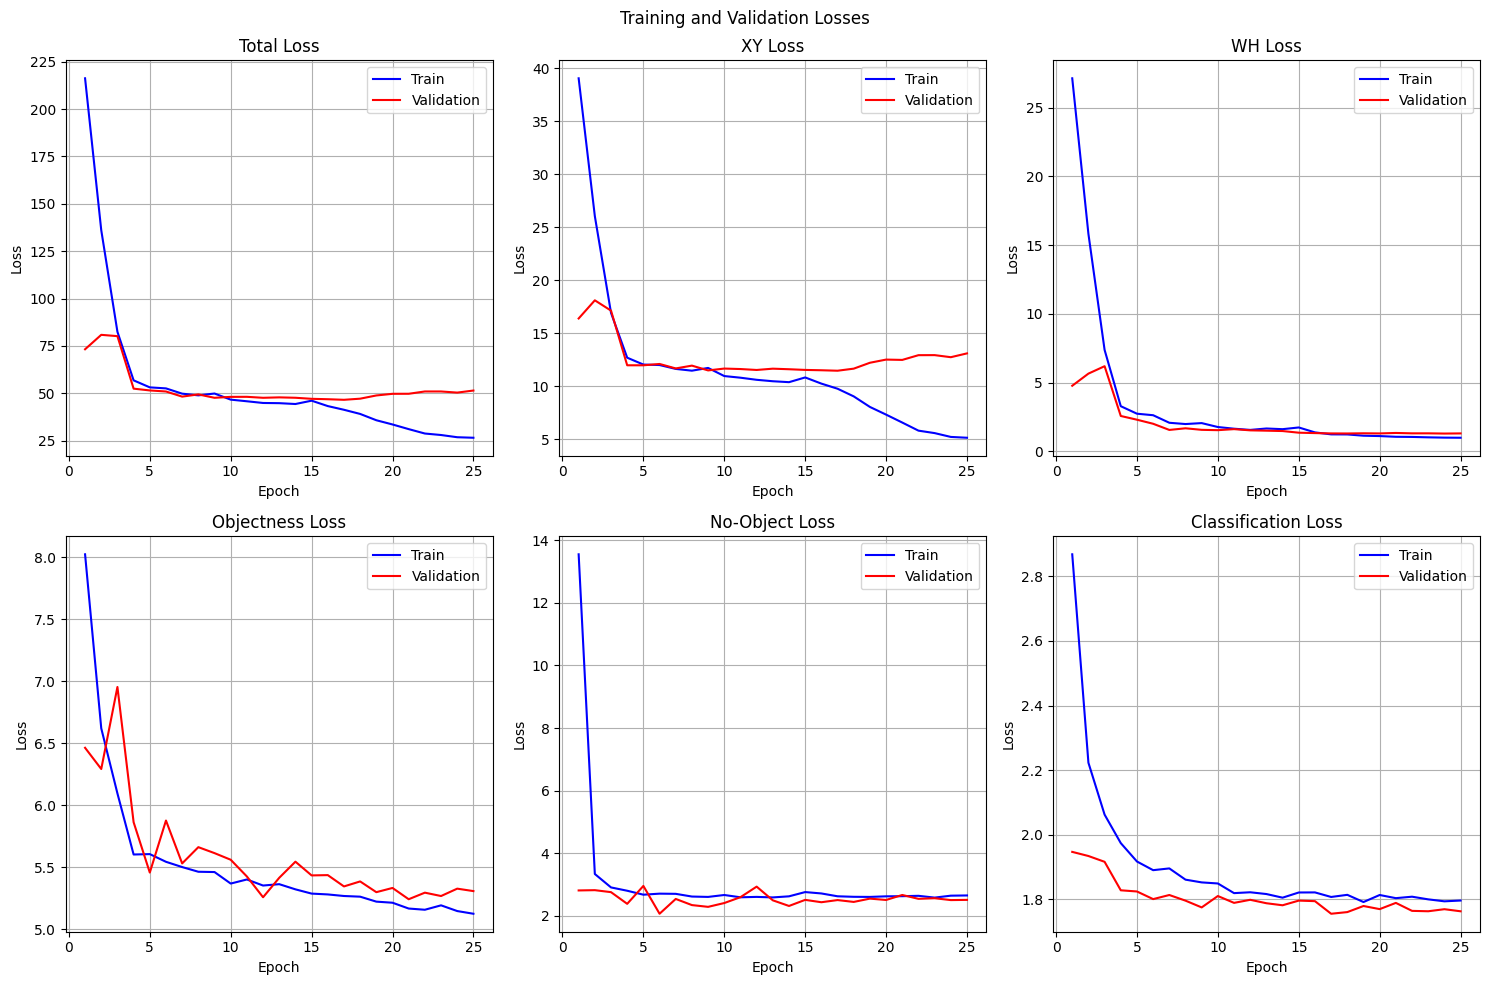

In [7]:
def save_checkpoint(model, optimizer, scheduler, epoch, loss, filepath):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,
    }, filepath)

def load_checkpoint(model, optimizer, scheduler, filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return epoch, loss

def plot_losses(train_losses, val_losses, save_path=None):
    import matplotlib.pyplot as plt
    epochs = range(1, len(train_losses['total']) + 1)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Training and Validation Losses')
    
    loss_types = ['total', 'xy', 'wh', 'obj', 'noobj', 'cls']
    titles = ['Total Loss', 'XY Loss', 'WH Loss', 'Objectness Loss', 'No-Object Loss', 'Classification Loss']
    
    for i, (loss_type, title) in enumerate(zip(loss_types, titles)):
        ax = axes[i//3, i%3]
        ax.plot(epochs, train_losses[loss_type], 'b-', label='Train')
        ax.plot(epochs, val_losses[loss_type], 'r-', label='Validation')
        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
        print(f"CUDA available: Using GPU - {torch.cuda.get_device_name()}")
    elif torch.backends.mps.is_available():
        device = 'mps'
        print("MPS available: Using Apple Silicon GPU")
    else:
        device = 'cpu'
        print("Using CPU")
    return device

def main():
    config = {
        'experiment_name': 'resnet50_YOLO_improved_regularization_grid_size_14',
        'batch_size': 16,
        'num_epochs': 25,
        'freeze_backbone_epochs': 15,
        'device': get_device(),
        'target_size': (224, 224),
        'lr': 3e-4,  
        'weight_decay': 1e-2,  
        'dropout_rate': 0.15,
    }
    
    print(f"Using device: {config['device']}")
    device = torch.device(config['device'])
    
    save_dir = "checkpoints" / Path(config['experiment_name'])
    save_dir.mkdir(parents=True, exist_ok=True)

    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(val_loader.dataset)}")
    
    model = ResNetYOLODetector(
        anchor_boxes=anchors, 
        backbone_name="resnet50", 
        freeze_backbone_epochs=config['freeze_backbone_epochs'],
        grid_size=14,
        dropout_rate=config['dropout_rate']
    ).to(device)
    
    info = model.get_model_info()
    print("Model Information:")
    for key, value in info.items():
        print(f"  {key}: {value:,}" if isinstance(value, int) else f"  {key}: {value}")
    
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=config['lr'], 
        weight_decay=config['weight_decay']
    )
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=config['num_epochs'],
        eta_min=config['lr'] * 0.01
    )
    
    train_history = {'total': [], 'xy': [], 'wh': [], 'obj': [], 'noobj': [], 'cls': []}
    val_history = {'total': [], 'xy': [], 'wh': [], 'obj': [], 'noobj': [], 'cls': []}
    
    best_val_loss = float('inf')
    
    for epoch in range(1, config['num_epochs'] + 1):
        print(f"\nEpoch {epoch}/{config['num_epochs']}")
        print("-" * 50)
        
        train_losses = train_epoch(model, anchors, train_loader, optimizer, scheduler, device, epoch)
        val_losses = validate_epoch(model, anchors, val_loader, device)
        
        print(f"Train - Total: {train_losses['total']:.4f}, "
              f"XY: {train_losses['xy']:.4f}, "
              f"WH: {train_losses['wh']:.4f}, "
              f"Obj: {train_losses['obj']:.4f}, "
              f"NoObj: {train_losses['noobj']:.4f}, "
              f"Cls: {train_losses['cls']:.4f}")
        
        print(f"Val   - Total: {val_losses['total']:.4f}, "
              f"XY: {val_losses['xy']:.4f}, "
              f"WH: {val_losses['wh']:.4f}, "
              f"Obj: {val_losses['obj']:.4f}, "
              f"NoObj: {val_losses['noobj']:.4f}, "
              f"Cls: {val_losses['cls']:.4f}")
        
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.2e}")
        
        for key in train_history:
            train_history[key].append(train_losses[key])
            val_history[key].append(val_losses[key])
        
        if val_losses['total'] < best_val_loss:
            best_val_loss = val_losses['total']
            save_checkpoint(
                model, optimizer, scheduler, epoch, val_losses['total'],
                save_dir / 'best_model.pth'
            )
            print(f"Saved best model with validation loss: {best_val_loss:.4f}")
    
    plot_losses(train_history, val_history, 
                save_path=save_dir / 'training_curves.png')
    

main()

MPS available: Using Apple Silicon GPU


Using cache found in /Users/tobysmith/.cache/torch/hub/pytorch_vision_v0.10.0


Backbone resnet50 configured for 14x14 grid
Output channels: 2048
Approximate backbone parameters: 23.5M
Loaded model from checkpoints/resnet50_YOLO_improved_regularization_grid_size_14/best_model.pth
Model was trained for 17 epochs
Best validation loss: 46.6122
Loaded anchors from model: tensor([[ 2.1473,  2.4237],
        [ 5.5996,  6.3885],
        [ 9.8380, 10.5782]], device='mps:0')
Image 1: ./cat_and_dog.jpg
  Detections: 3
  Cats: 0, Dogs: 0


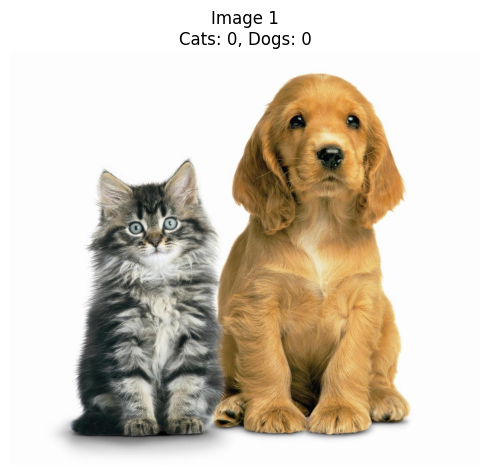

In [15]:
def load_model_for_inference(model_path, device='cpu'):
    dummy_anchors = torch.tensor([[1.0, 1.0], [2.0, 2.0], [3.0, 3.0]])  
    model = ResNetYOLODetector(
        anchor_boxes=dummy_anchors,
        backbone_name="resnet50", 
        freeze_backbone_epochs=12,
        grid_size=14
    ).to(device)
    
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"Loaded model from {model_path}")
    print(f"Model was trained for {checkpoint['epoch']} epochs")
    print(f"Best validation loss: {checkpoint['loss']:.4f}")
    print(f"Loaded anchors from model: {model.anchors}")
    
    return model

def inference_on_images(model, image_paths, device='cpu', conf_threshold=0.2, target_size=(224, 224)):
    from PIL import Image, ImageDraw, ImageFont
    import torchvision.transforms as transforms
    
    anchors = model.anchors
    
    if isinstance(image_paths, str):
        image_paths = [image_paths]
    
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    class_names = {0: 'dog', 1: 'cat'}
    colors = {0: 'red', 1: 'blue'}
    
    num_images = len(image_paths)
    cols = min(3, num_images)
    rows = (num_images + cols - 1) // cols
    
    _, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    if num_images == 1:
        axes = [axes]
    elif rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()
    
    model.eval()
    with torch.no_grad():
        for idx, image_path in enumerate(image_paths):
            original_image = Image.open(image_path).convert('RGB')
            original_size = original_image.size
            
            input_tensor = transform(original_image).unsqueeze(0).to(device)
            
            predictions = model(input_tensor)
            
            detections = decode_yolo_predictions(predictions, anchors, conf_threshold=conf_threshold)
            
            scale_x = original_size[0] / target_size[0]
            scale_y = original_size[1] / target_size[1]
            
            draw_image = original_image.copy()
            draw = ImageDraw.Draw(draw_image)
            
            detection_count = {'cat': 0, 'dog': 0}
            
            if len(detections) > 0 and len(detections[0]) > 0:
                boxes = detections[0]['boxes']
                scores = detections[0]['scores']
                labels = detections[0]['labels']

                for i in range(len(boxes)):
                    x1, y1, x2, y2 = boxes[i]
                    conf = scores[i]
                    cls = labels[i]
                    
                    x1 = int(x1 * scale_x)
                    y1 = int(y1 * scale_y)
                    x2 = int(x2 * scale_x)
                    y2 = int(y2 * scale_y)
                    
                    class_id = int(cls)
                    class_name = class_names[class_id]
                    color = colors[class_id]
                    detection_count[class_name] += 1
 
                    draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
                    
                    label = f'{class_name}: {conf:.2f}'
                    
                    try:
                        font = ImageFont.truetype("/System/Library/Fonts/Arial.ttf", 16)
                    except:
                        font = ImageFont.load_default()
                    
                    bbox = draw.textbbox((0, 0), label, font=font)
                    text_width = bbox[2] - bbox[0]
                    text_height = bbox[3] - bbox[1]
                    
                    draw.rectangle([x1, y1-text_height-4, x1+text_width+4, y1], fill=color)
                    draw.text((x1+2, y1-text_height-2), label, fill='white', font=font)
            
            ax = axes[idx] if num_images > 1 else axes[0]
            ax.imshow(draw_image)
            ax.set_title(f'Image {idx+1}\nCats: {detection_count["cat"]}, Dogs: {detection_count["dog"]}')
            ax.axis('off')
            
            print(f"Image {idx+1}: {image_path}")
            print(f"  Detections: {len(detections[0]) if len(detections) > 0 else 0}")
            print(f"  Cats: {detection_count['cat']}, Dogs: {detection_count['dog']}")
    
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Load your trained model (anchors automatically loaded from model)
model_path = "checkpoints/resnet50_YOLO_improved_regularization_grid_size_14/best_model.pth"
device = get_device()

# Load the model - anchors are now loaded automatically from the saved model
model = load_model_for_inference(model_path, device)

# Test on single image
inference_on_images(model, "./cat_and_dog.jpg", device)

# Test on multiple images
# image_paths = ["path/to/image1.jpg", "path/to/image2.jpg", "path/to/image3.jpg"]
# inference_on_images(model, image_paths, device)